In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

The question comes from [this math exchange post](https://math.stackexchange.com/questions/3497204/honest-vs-dishonest-voting-does-it-matter).

We need to simulate two kinds of agents:
   1. One set who vote actually based on their preferences - "true voters"
   2. The other set votes 0, or 10 based on which direction they want the average to move in - "strategic voters"

Everyone gets randomly assigned a "true" preference $p \in [0, 10]$ generated by a truncated normal distribution.

Coding wise, its straightforward to generate the votes for the "true" voters. It's just equal to their preferences.

For the strategic voters we need to think of how the game proceeds:
   1. A given strategic voter looks at the current average vote
   2. He then calculates how much he needs to vote to move the average close to his preference. The formula he uses for this is simple. Given his true preference $p$, he chooses his vote $v$ based on the current average $A$ and the number of people who have voted already $n$ by the following formula $v = p(n + 1) - An$. Subject to $v \in [0, 10]$. 
   3. Time wise in simulations where we mix both types of agents, true voters go first, and then in a random order, the strategic voters follow one by one.

In [2]:
class truevoter():
    
    def __init__(self, n, mu = 5, sigma = 1):
        # initiate preference matrix
        self.prefs = stats.truncnorm(
            (0 - mu) / sigma, (10 - mu) / sigma,
            loc=mu, scale=sigma).rvs(n)
        
    def votes(self):
        # for these guys their preferences are their votes
        votes = self.prefs
        
        return votes
    
    def get_output(self):
        
        # get relevant outputs
        true_prefmat = self.prefs
        true_votingmat = self.votes()
        true_voters_avg = true_votingmat.mean()
        
        return true_prefmat, true_votingmat, true_voters_avg
        
class stratvoter():
    
    def __init__(self, n, mu = 5, sigma = 1):
        # initiate preference matrix
        self.prefs = stats.truncnorm(
            (0 - mu) / sigma, (10 - mu) / sigma,
            loc=mu, scale=sigma).rvs(n)
        
    def votes(self, currentaverage, currentn):
        
        # update votes iteratively
        prefs = self.prefs
        A = currentaverage
        n = currentn
        votes = np.empty_like(prefs)
        
        for p_i, p in enumerate(prefs):
            # get vote of individual
            vote = p * (n + 1) - A * n
            if vote > 10:
                votes[p_i] = 10
            elif vote < 0:
                votes[p_i] = 0
            else:
                votes[p_i] = vote
            
            # update values
            n += 1
            A = (A * n + votes[p_i])/(n + 1)
            
        return votes
    
    def get_output(self, currentaverage, currentn):
        
        # get relevant outputs
        strat_prefmat = self.prefs
        strat_votingmat = self.votes(currentaverage, 
                                currentn)
        strat_voters_avg = strat_votingmat.mean()
        
        return strat_prefmat, strat_votingmat, strat_voters_avg

In [3]:
def mc_simul(mu = 1, sigma = 1, n_simul = 1000,
            ntrue = 100,
            nstrat = 100):

    # == Monte Carlo Simulations == #
    
    # initialize empty matrices for storing results
    prefs_avg_mat = np.empty(n_simul)
    voting_avg_mat = np.empty_like(prefs_avg_mat)

    for i in range(n_simul):
        
        # get outputs of voters
        true_prefmat, true_votingmat, true_voters_avg  = (
                                                        truevoter(ntrue,
                                                                  mu = mu,
                                                                  sigma = sigma)
                                                        .get_output()
                                                        )
        strat_prefmat, strat_votingmat, strat_voters_avg  = (
                                                            stratvoter(nstrat, 
                                                                       mu = mu,
                                                                       sigma = sigma)
                                                            .get_output(true_voters_avg,
                                                                        ntrue)
                                                            )
        
        # calculate average preferences and average vote
        true_pref_avg = (true_prefmat.sum() + strat_prefmat.sum())/(ntrue + nstrat)
        actual_vote_avg = (true_votingmat.sum() + strat_votingmat.sum())/(ntrue + nstrat)
        
        # store in matrix
        prefs_avg_mat[i] = true_pref_avg
        voting_avg_mat[i] = actual_vote_avg
        
    return prefs_avg_mat, voting_avg_mat

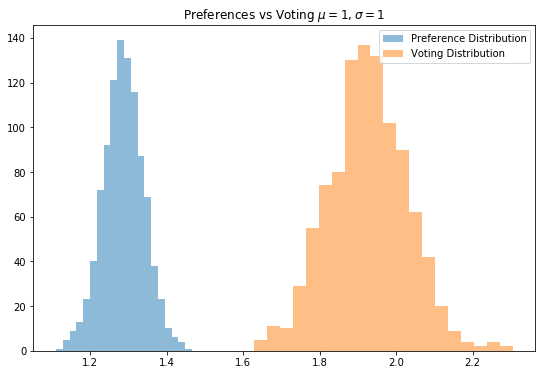

In [4]:
# plotting
mu = 1
sigma = 1
prefs_avg_mat, voting_avg_mat = mc_simul(mu, sigma)
fig, ax = plt.subplots(figsize = (9, 6))
ax.hist(prefs_avg_mat, label = "Preference Distribution", alpha = 0.5, bins = 20)
ax.hist(voting_avg_mat, label = "Voting Distribution", alpha = 0.5, bins = 20)
ax.legend()
ax.set_title(f"Preferences vs Voting $\mu = {mu}, \sigma = {sigma}$")
plt.show()

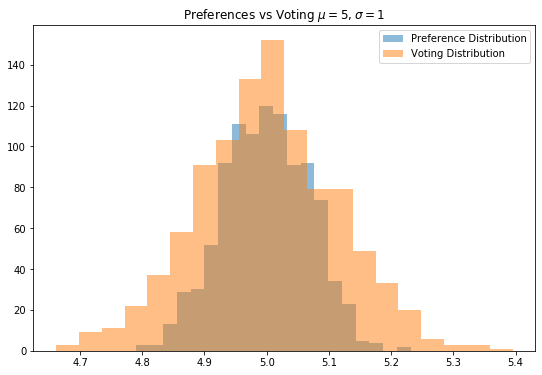

In [5]:
# plotting
mu = 5
sigma = 1
prefs_avg_mat, voting_avg_mat = mc_simul(mu, sigma)
fig, ax = plt.subplots(figsize = (9, 6))
ax.hist(prefs_avg_mat, label = "Preference Distribution", alpha = 0.5, bins = 20)
ax.hist(voting_avg_mat, label = "Voting Distribution", alpha = 0.5, bins = 20)
ax.legend()
ax.set_title(f"Preferences vs Voting $\mu = {mu}, \sigma = {sigma}$")
plt.show()

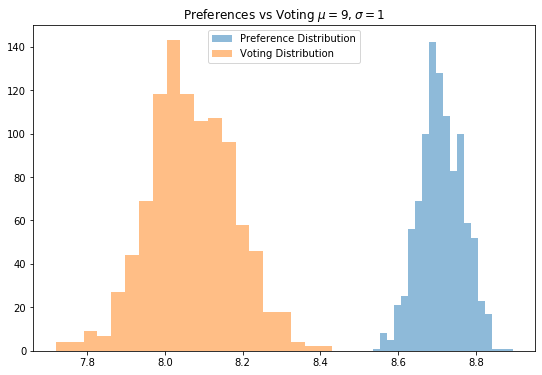

In [6]:
# plotting
mu = 9
sigma = 1
prefs_avg_mat, voting_avg_mat = mc_simul(mu, sigma)
fig, ax = plt.subplots(figsize = (9, 6))
ax.hist(prefs_avg_mat, label = "Preference Distribution", alpha = 0.5, bins = 20)
ax.hist(voting_avg_mat, label = "Voting Distribution", alpha = 0.5, bins = 20)
ax.legend()
ax.set_title(f"Preferences vs Voting $\mu = {mu}, \sigma = {sigma}$")
plt.show()

What we have established is that if the true preference distribution is centered around $\mu = 5$ (which is the mid point of our domain), voting choice is a consistent estimator of preferences. Note that it may not be efficient since the standard deviation of voting seems to be much larger than the standard deviation of preferences because often times when strategic voters need to shift the vote, they vote either a 0 or a 10, which is unlikely to be their true prefererence.

As the preference distribution mean gets closer to the edges of the domain (that is either 0 or 10), we see that voting choice is no longer consistent. It is always biased towards 5 in general. That is, if the mean of preferences is 9, then the mean of voting choices will be lower than 9. if the mean of preferences is 1, then the mean of voting choices will be higher than 1. This is because if the preference distribution is centered around a corner, strategic voters exert less influence individually on the average vote. Therefore there will be more strategic voters who will vote the extreme vote to move the average vote.